## Imports

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import numpy as np

import tensorflow as tf
print(f"GPUs: {len(tf.config.list_physical_devices('GPU'))}")
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import random_normal
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from DataGen import VQASequence
from json_to_df import gen_df

GPUs: 1


## Hyperparameters

In [24]:
img_size = 224
img_input_shape = (img_size, img_size, 3)
qstn_input_shape = (None, 300)
n_most_freq = 200
seed = 14
test_size = 0.2
learning_rate = 1e-3
batch_size = 256
epochs=100
latent_dim = 500

## Data

In [14]:
train_df = gen_df('train')
val_df = gen_df('val')

df = pd.concat([train_df, val_df])

most_freq = df.Question.value_counts().head(n_most_freq).index
df = df[df.Question.isin(most_freq)]

train_df, temp_df = train_test_split(df, test_size=test_size, stratify=df.Question, random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df.Question, random_state=seed)

(array(['no', 'yes'], dtype=object), array([930, 749], dtype=int64))


<AxesSubplot:>

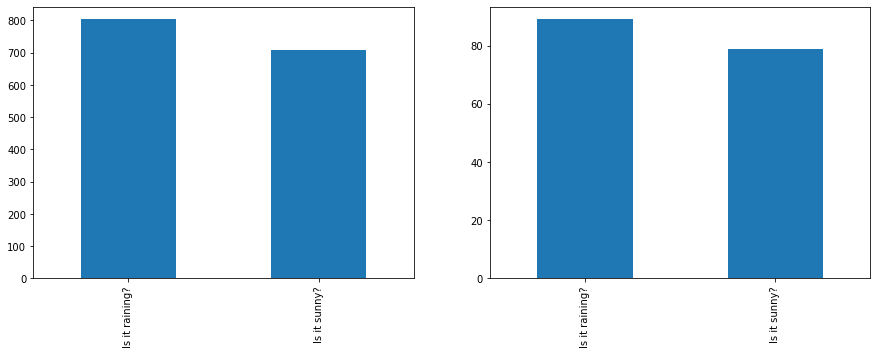

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

train_df.Question.value_counts()[:20].plot.bar(ax=axes[0])
val_df.Question.value_counts()[:20].plot.bar(ax=axes[1])
test_df.Question.value_counts()[:20].plot.bar(ax=axes[2])

In [16]:
train_gen = VQASequence(batch_size, train_df, img_size)
val_gen = VQASequence(batch_size, val_df, img_size)
test_gen = VQASequence(batch_size, test_df, img_size)

## Model

In [19]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        # print(z_mean.shape, z_log_var.shape)
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [25]:
img_in = Input(shape=img_input_shape)

img_encoding = Sequential([
    Conv2D(8, 3, strides=2, padding='same', activation='relu'),
    Conv2D(16, 3, strides=2, padding='same', activation='relu'),
    Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    Conv2D(64, 3, strides=2, padding='same', activation='relu'),
    Conv2D(128, 3, strides=2, padding='same', activation='relu'),
    Flatten()
])(img_in)

qstn_in = Input(shape=qstn_input_shape)

q_encoding = Sequential([
    LSTM(64, activation='tanh'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
])(qstn_in)

concat_layer = Concatenate(axis=-1)([img_encoding, q_encoding])
logvar = Dense(latent_dim)(img_encoding)
mean = Dense(latent_dim)(q_encoding)

z = Sampling()([mean, logvar])

decoded = Sequential([
    Dense(8 * 8 * 128, activation='relu'),
    Reshape((8, 8, 128)),
    Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid'),
    Flatten()
])(z)

output = Sequential([
    Dense(latent_dim),
    LeakyReLU(),
    Dense(latent_dim),
    LeakyReLU(),
    Dense(1, activation='sigmoid')
])(decoded)

model = Model(
    inputs=[img_in, qstn_in], 
    outputs=output, 
    name='CVAE_VQA'
)


In [28]:
metrics = ['accuracy', 'AUC', 'Precision', 'Recall']

model.compile(
    optimizer=Adam(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=metrics
)

rp = ReduceLROnPlateau(patience=5)
es = EarlyStopping(patience=15)

callbacks= [rp, es]

## Train

In [29]:
%%time

hist = model.fit(
    x=train_gen,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_gen,
    callbacks=callbacks
)


3/3 [==============================] - 21s 8s/step - loss: 6.2078 - accuracy: 0.4799 - auc: 0.4890 - recall: 0.5322 - precision: 0.4277 - val_loss: 1.1056 - val_accuracy: 0.4524 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.4524


## Plot

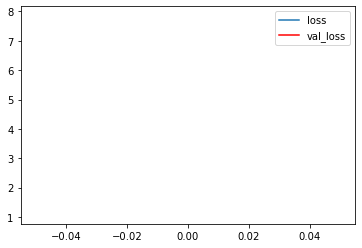

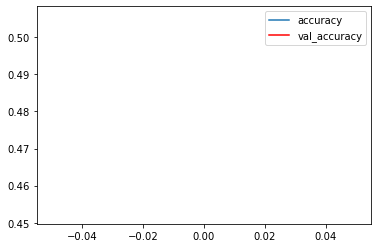

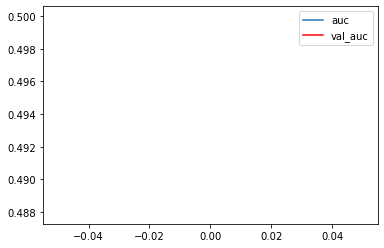

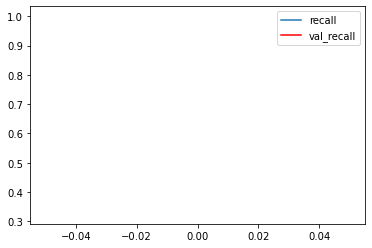

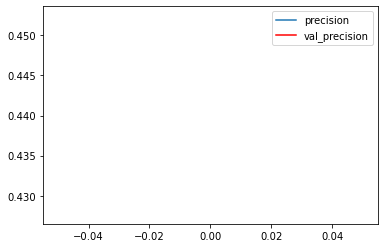

In [30]:
pickle.dump(hist.history, open(f'./{model.name}.pickle', 'wb'))

def plot(history, metrics):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss', color='red')
    plt.legend()
    plt.figsave(f'./plots/{model.name}_loss.png')
    plt.show()
    
    for metric in metrics:
        metric = metric.lower()
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}', color='red')
        plt.legend()
        plt.figsave(f'./plots/{model.name}_{metric}.png')
        plt.show()
    
plot(model.history, metrics)

## Evaluation

In [ ]:
evaluate = model.evaluate(x=test_gen, batch_size=batch_size, verbose=0)

results_dict = {
    'Name' : model.name,
    'Loss' : [evaluate[0]],
    'Accuracy' : [evaluate[1]],
    'AUC' : [evaluate[2]],
    'Precision' : [evaluate[3]],
    'Recall' : [evaluate[4]]
}

test_results = pd.DataFrame(data=results_dict)
test_results.head(1)
test_resuls.to_csv(f'./results/{model.name}_results.png')